In [1]:
%load_ext autoreload
%autoreload 2

# Tutorial

In this file we show how you can easily build a custom pipeline to run our ensemble optimization method

## WARNING 

This assumes you already ran the data generation tutorial. If you haven't the data will not exists.

In [2]:
import os

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mdtraj
import yaml
from cryojax.data import (
    RelionParticleParameterFile,
    RelionParticleStackDataset,
)

import cryojax_ensemble_optimization as cxsopt

/mnt/home/dsilvasanchez/virtual_envs/cryojax-er-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:558: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/home/dsilvasanchez/virtual_envs/cryojax-er-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:90: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/home/dsilvasanchez/virtual_envs/cryojax-er-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:558: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/home/dsilvasanchez/virtual_envs/cryojax-er-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:90: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.sm

In [3]:
with open("./ensemble_optimization_config.yaml", "r") as f:
    config_file = yaml.safe_load(f)
    config = dict(cxsopt.internal.cryojaxERConfig(**config_file).model_dump())

# create output directory if it does not exist
os.makedirs(config["path_to_output"], exist_ok=True)

In [4]:
config

{'path_to_atomic_models': ['atomic_models/initial_model_0.pdb',
  'atomic_models/initial_model_1.pdb'],
 'path_to_reference_model': './atomic_models/ref_model.pdb',
 'path_to_starfile': PosixPath('../data_generation/tutorial_data/tutorial_alanine.star'),
 'path_to_relion_project': PosixPath('../data_generation/tutorial_data'),
 'loads_envelope': False,
 'path_to_output': PosixPath('outputs'),
 'projector_params': {'projector_mode': 'openmm',
  'n_steps': 200,
  'bias_constant_in_units': 50000.0,
  'platform': 'CPU',
  'platform_properties': {'Threads': '64'},
  'path_to_initial_states': None},
 'likelihood_optimizer_params': {'n_steps': 5,
  'step_size': 0.25,
  'batch_size': 100,
  'init_weights': Array([0.5, 0.5], dtype=float32),
  'noise_variance': None,
  'image_to_walker_log_likelihood_fn': 'iso_gaussian_var_marg'},
 'n_steps': 200,
 'atom_selection': 'not element H',
 'loads_b_factors': True,
 'rng_seed': 0}

# Load the atomic models and dataset

* The atomic models contain the atomic positions and the scattering factors used to simulate images
* The reference structure is used for alignment (it should be aligned with the pose information of the images!!)
* The restrain atom list is used for selecting which atoms get optimized, and which atoms are used in the biasing force of the steered MD

In [5]:
atomic_models = cxsopt.io.read_atomic_models(
    config["path_to_atomic_models"], loads_b_factors=True
)

ref_structure = mdtraj.load(config["path_to_reference_model"])
# center the reference structure
ref_structure = ref_structure.center_coordinates()
restrain_atom_list = ref_structure.topology.select(config["atom_selection"])

Parse the atomic models, and filter the scattering parameters

In [6]:
walkers = jnp.array([model["atom_positions"] for model in atomic_models.values()])
gaussian_variances = jnp.array(
    [model["gaussian_variances"] for model in atomic_models.values()]
)[:, restrain_atom_list]
gaussian_amplitudes = jnp.array(
    [model["gaussian_amplitudes"] for model in atomic_models.values()]
)[:, restrain_atom_list]

walkers.shape, gaussian_variances.shape, gaussian_amplitudes.shape

((2, 42, 3), (2, 20, 5), (2, 20, 5))

Load the cryo-EM data. The dataloader is used to load by random batches

In [7]:
stack_dataset = RelionParticleStackDataset(
    RelionParticleParameterFile(
        path_to_starfile=config["path_to_starfile"],
        mode="r",
        loads_envelope=False,
    ),
    path_to_relion_project=config["path_to_relion_project"],
    mode="r",
)

key = jax.random.PRNGKey(config["rng_seed"])
key_data, key_pipeline = jax.random.split(key)

dataloader = cxsopt.data.create_dataloader(
    stack_dataset,
    batch_size=config["likelihood_optimizer_params"]["batch_size"],
    shuffle=True,
    drop_last=False,
    jax_prng_key=key_data,
    per_particle_args=None,
)

The last argument can be used to pass additional arguments for each particle that cannot be found in the starfile. For example, noise parameters. These parameters can be useful to define custom log likelihood functions, as we show below.

# Construct the objects necessary for the ensemble optimization

## The prior projector

This is simply a list of single projector, you should define one projector for each walker!. The `base_state_file_path` argument is used to save the current state of the simulation at each iteration of the ensemble optimization. This should be different for each projector! This is useful for continuing previous iterations of the method.

In [8]:
projector_list = []

for i in range(2):
    projector_list.append(
        cxsopt.ensemble_optimization.SteeredMDSimulator(
            path_to_initial_pdb=config["path_to_atomic_models"][i],
            bias_constant_in_kj_per_mol_angs=config["projector_params"][
                "bias_constant_in_units"
            ],
            n_steps=config["projector_params"]["n_steps"],
            restrain_atom_list=restrain_atom_list,
            parameters_for_md={
                "platform": config["projector_params"]["platform"],
                "properties": config["projector_params"]["platform_properties"],
            },
            base_state_file_path=os.path.join(
                config["path_to_output"], f"states_proj_{i}/state_"
            ),
            make_simulation_fn=None,  # see below!
        )
    )
md_projector = cxsopt.ensemble_optimization.EnsembleSteeredMDSimulator(projector_list)

The way the steered MD simulations can be easily personalized. You can provide your own `make_simulation_fn` which should take an openmm topology object (coming from the `path_to_initial_pdb`) and a dictionary (`parameters_for_md`). For example, the default function is defined as

```python

import openmm
import openmm.app as openmm_app
import openmm.unit as openmm_unit

def _create_forcefield(parameters_for_md: dict) -> openmm_app.ForceField:
    return openmm_app.ForceField(
        parameters_for_md["forcefield"], parameters_for_md["water_model"]
    )


def _create_integrator(parameters_for_md: dict) -> openmm.Integrator:
    return openmm.LangevinIntegrator(
        parameters_for_md["temperature"],
        parameters_for_md["friction"],
        parameters_for_md["timestep"],
    )


def _create_system(
    parameters_for_md: dict,
    forcefield: openmm_app.ForceField,
    topology: openmm_app.Topology,
) -> openmm.System:
    system = forcefield.createSystem(
        topology,
        nonbondedMethod=parameters_for_md["nonbondedMethod"],
        nonbondedCutoff=parameters_for_md["nonbondedCutoff"],
        constraints=parameters_for_md["constraints"],
    )

    return system


def _create_platform(parameters_for_md: dict) -> openmm.Platform:
    return openmm.Platform.getPlatformByName(parameters_for_md["platform"])

def _default_make_sim_fn(parameters_for_md: dict, topology) -> openmm_app.Simulation:
    forcefield = _create_forcefield(parameters_for_md)
    integrator = _create_integrator(parameters_for_md)
    platform = _create_platform(parameters_for_md)
    system = _create_system(parameters_for_md, forcefield, topology)

    simulation = openmm_app.Simulation(
        topology,
        system,
        integrator,
        platform,
        parameters_for_md["properties"],
    )

    return simulation
```

In the default case, the `parameters_for_md` argument is completed with these default parameters

```python
DEFAULT_MD_PARAMS = {
    "forcefield": "amber14-all.xml",
    "water_model": "amber14/tip3p.xml",
    "nonbondedMethod": openmm_app.PME,
    "nonbondedCutoff": 1.0 * openmm_unit.nanometer,
    "constraints": openmm_app.HBonds,
    "temperature": 300.0 * openmm_unit.kelvin,
    "friction": 1.0 / openmm_unit.picosecond,
    "timestep": 0.002 * openmm_unit.picoseconds,
    "platform": "CPU",
    "properties": {"Threads": "1"},
}

```

## The likelihood optimizer

In [9]:
likelihood_optimizer = cxsopt.ensemble_optimization.IterativeEnsembleLikelihoodOptimizer(
    step_size=config["likelihood_optimizer_params"]["step_size"],
    n_steps=config["likelihood_optimizer_params"]["n_steps"],
    gaussian_variances=gaussian_variances[:, restrain_atom_list],
    gaussian_amplitudes=gaussian_amplitudes[:, restrain_atom_list],
    image_to_walker_log_likelihood_fn="iso_gaussian_var_marg",
)

The likelihood optimizer can also be personalized. The `image_to_walker_log_likelihood_fn` can be also passed as a callable with structure

```python
def my_loglikelihood_fn(
    computed_image: Image,
    observed_image: Image,
    per_particle_args: Any
):
    log_likelihood = ...
    return log_likelihood
```

This functions needs to be jit compilable with equinox. Otherwise this will not work. The per_particle_args can be passed as pytree with the same batch dimension as the stack when defining the dataloader (see the above). The arguments for each image should match their order in the starfile.

## The ensemble refinement pipeline

In [10]:
ensemble_refinement_pipeline = cxsopt.ensemble_optimization.EnsembleOptimizationPipeline(
    prior_projector=md_projector,
    likelihood_optimizer=likelihood_optimizer,
    n_steps=config["n_steps"],
    ref_structure_for_alignment=ref_structure,
    atom_indices_for_opt=restrain_atom_list,
    runs_postprocessing=True,
)

Now simply define the initial walkers and weights, and run!

If restarting, `the initial_state_for_projector` argument should be a list of paths to the initial states.

In [12]:
init_walkers = jnp.array(walkers)
init_weights = jnp.array(config["likelihood_optimizer_params"]["init_weights"])

walkers, weights = ensemble_refinement_pipeline.run(
    key=key_pipeline,
    initial_walkers=init_walkers,
    initial_weights=init_weights,
    dataloader=dataloader,
    output_directory=config["path_to_output"],
    initial_state_for_projector=None,
)

  0%|          | 0/200 [00:00<?, ?it/s]/mnt/home/dsilvasanchez/virtual_envs/cryojax-er-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:558: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/home/dsilvasanchez/virtual_envs/cryojax-er-env/lib/python3.10/site-packages/numpy/_core/getlimits.py:90: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
100%|██████████| 200/200 [09:01<00:00,  2.71s/it]


In [13]:
# These should be around 0.7 and 0.3

print(weights)

[0.30783808 0.6921618 ]


In [16]:
# The trajectories can be found in the output directory

traj0 = mdtraj.load(
    os.path.join(config["path_to_output"], "traj_walker_0.xtc"),
    top=config["path_to_reference_model"],
)

traj1 = mdtraj.load(
    os.path.join(config["path_to_output"], "traj_walker_1.xtc"),
    top=config["path_to_reference_model"],
)

# Let's also load the true members of the ensemble

true_ensemble_structure0 = mdtraj.load("../data_generation/atomic_models/ala_model_0.pdb")

true_ensemble_structure1 = mdtraj.load("../data_generation/atomic_models/ala_model_1.pdb")

atom_indices = true_ensemble_structure0.topology.select("not element H")
# now comute the RMSD of each trajectory to the true ensemble members
rmsd00 = mdtraj.rmsd(traj0, true_ensemble_structure0, 0)
rmsd01 = mdtraj.rmsd(traj0, true_ensemble_structure1, 0)

rmsd10 = mdtraj.rmsd(traj1, true_ensemble_structure0, 0)
rmsd11 = mdtraj.rmsd(traj1, true_ensemble_structure1, 0)

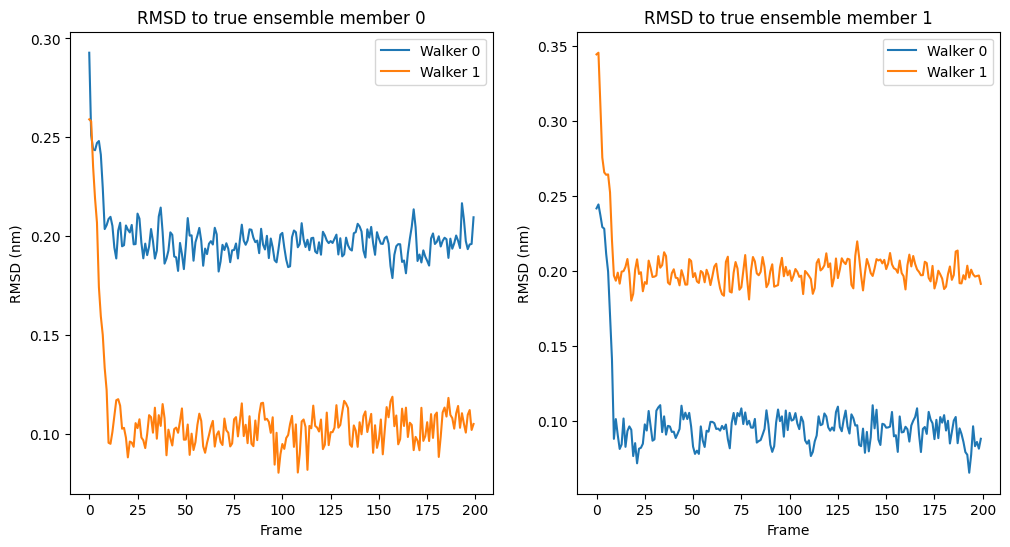

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(rmsd00, label="Walker 0")
ax[0].plot(rmsd10, label="Walker 1")
ax[0].set_title("RMSD to true ensemble member 0")
ax[0].set_xlabel("Frame")
ax[0].set_ylabel("RMSD (nm)")
ax[0].legend()

ax[1].plot(rmsd01, label="Walker 0")
ax[1].plot(rmsd11, label="Walker 1")
ax[1].set_title("RMSD to true ensemble member 1")
ax[1].set_xlabel("Frame")
ax[1].set_ylabel("RMSD (nm)")
ax[1].legend()

# Running from the command line

You could also simply run `cryojax_ensemble_optimization run_ensemble_optimization --config ensemble_optimization_config.yaml --nprocs <n_processors>`

The `--nprocs` argument can be used to overwrite how many threads OpenMM uses. This will probably be deprecated in the near future.

Although in this case it is not possible to define custom simulations and log likelihood functions.